In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
import pandas as pd
import cartopy.io.shapereader as shpreader



In [3]:
iho = gpd.read_file("/data/gpfs/projects/punim2504/msc_thesis/data/World_Seas_IHO_v3/World_Seas_IHO_v3.shp")
meta = pd.read_csv("/data/gpfs/projects/punim2504/msc_thesis/data/metadata_1446.csv")

# meta["IHO_Sea_comb"] = meta["IHO_Sea_fmt"].replace({
#     "Celtic Sea": "North Atlantic Ocean",
#     "Coral Sea":  "South Pacific Ocean"
# })
# meta.to_csv("/data/gpfs/projects/punim2504/msc_thesis/data/metadata_1446.csv", index=False)



In [4]:
label_seas = [
    "Indian Ocean", "North Atlantic Ocean", "North Pacific Ocean",
    "South Atlantic Ocean", "South Pacific Ocean",
    "Bay of Bengal", "Arabian Sea", "Mediterranean Sea",
    "Baltic Sea", "North Sea", "Arctic Ocean",
    "Southern Ocean", "Red Sea"
]

In [ ]:
# Generate a new column for combined sea names
iho["NAME_comb"] = iho["NAME"].replace({
    "Coral Sea":  "South Pacific Ocean",
    "Celtic Sea": "North Atlantic Ocean"
})

# dissolve by the new combined names to merge geometries
iho_all_diss = iho[["NAME_comb", "geometry"]].dissolve(by="NAME_comb", as_index=True)

# dissolve only the seas we want to label
iho_labels = iho[iho["NAME_comb"].isin(label_seas)][["NAME_comb", "geometry"]].dissolve(by="NAME_comb", as_index=True)


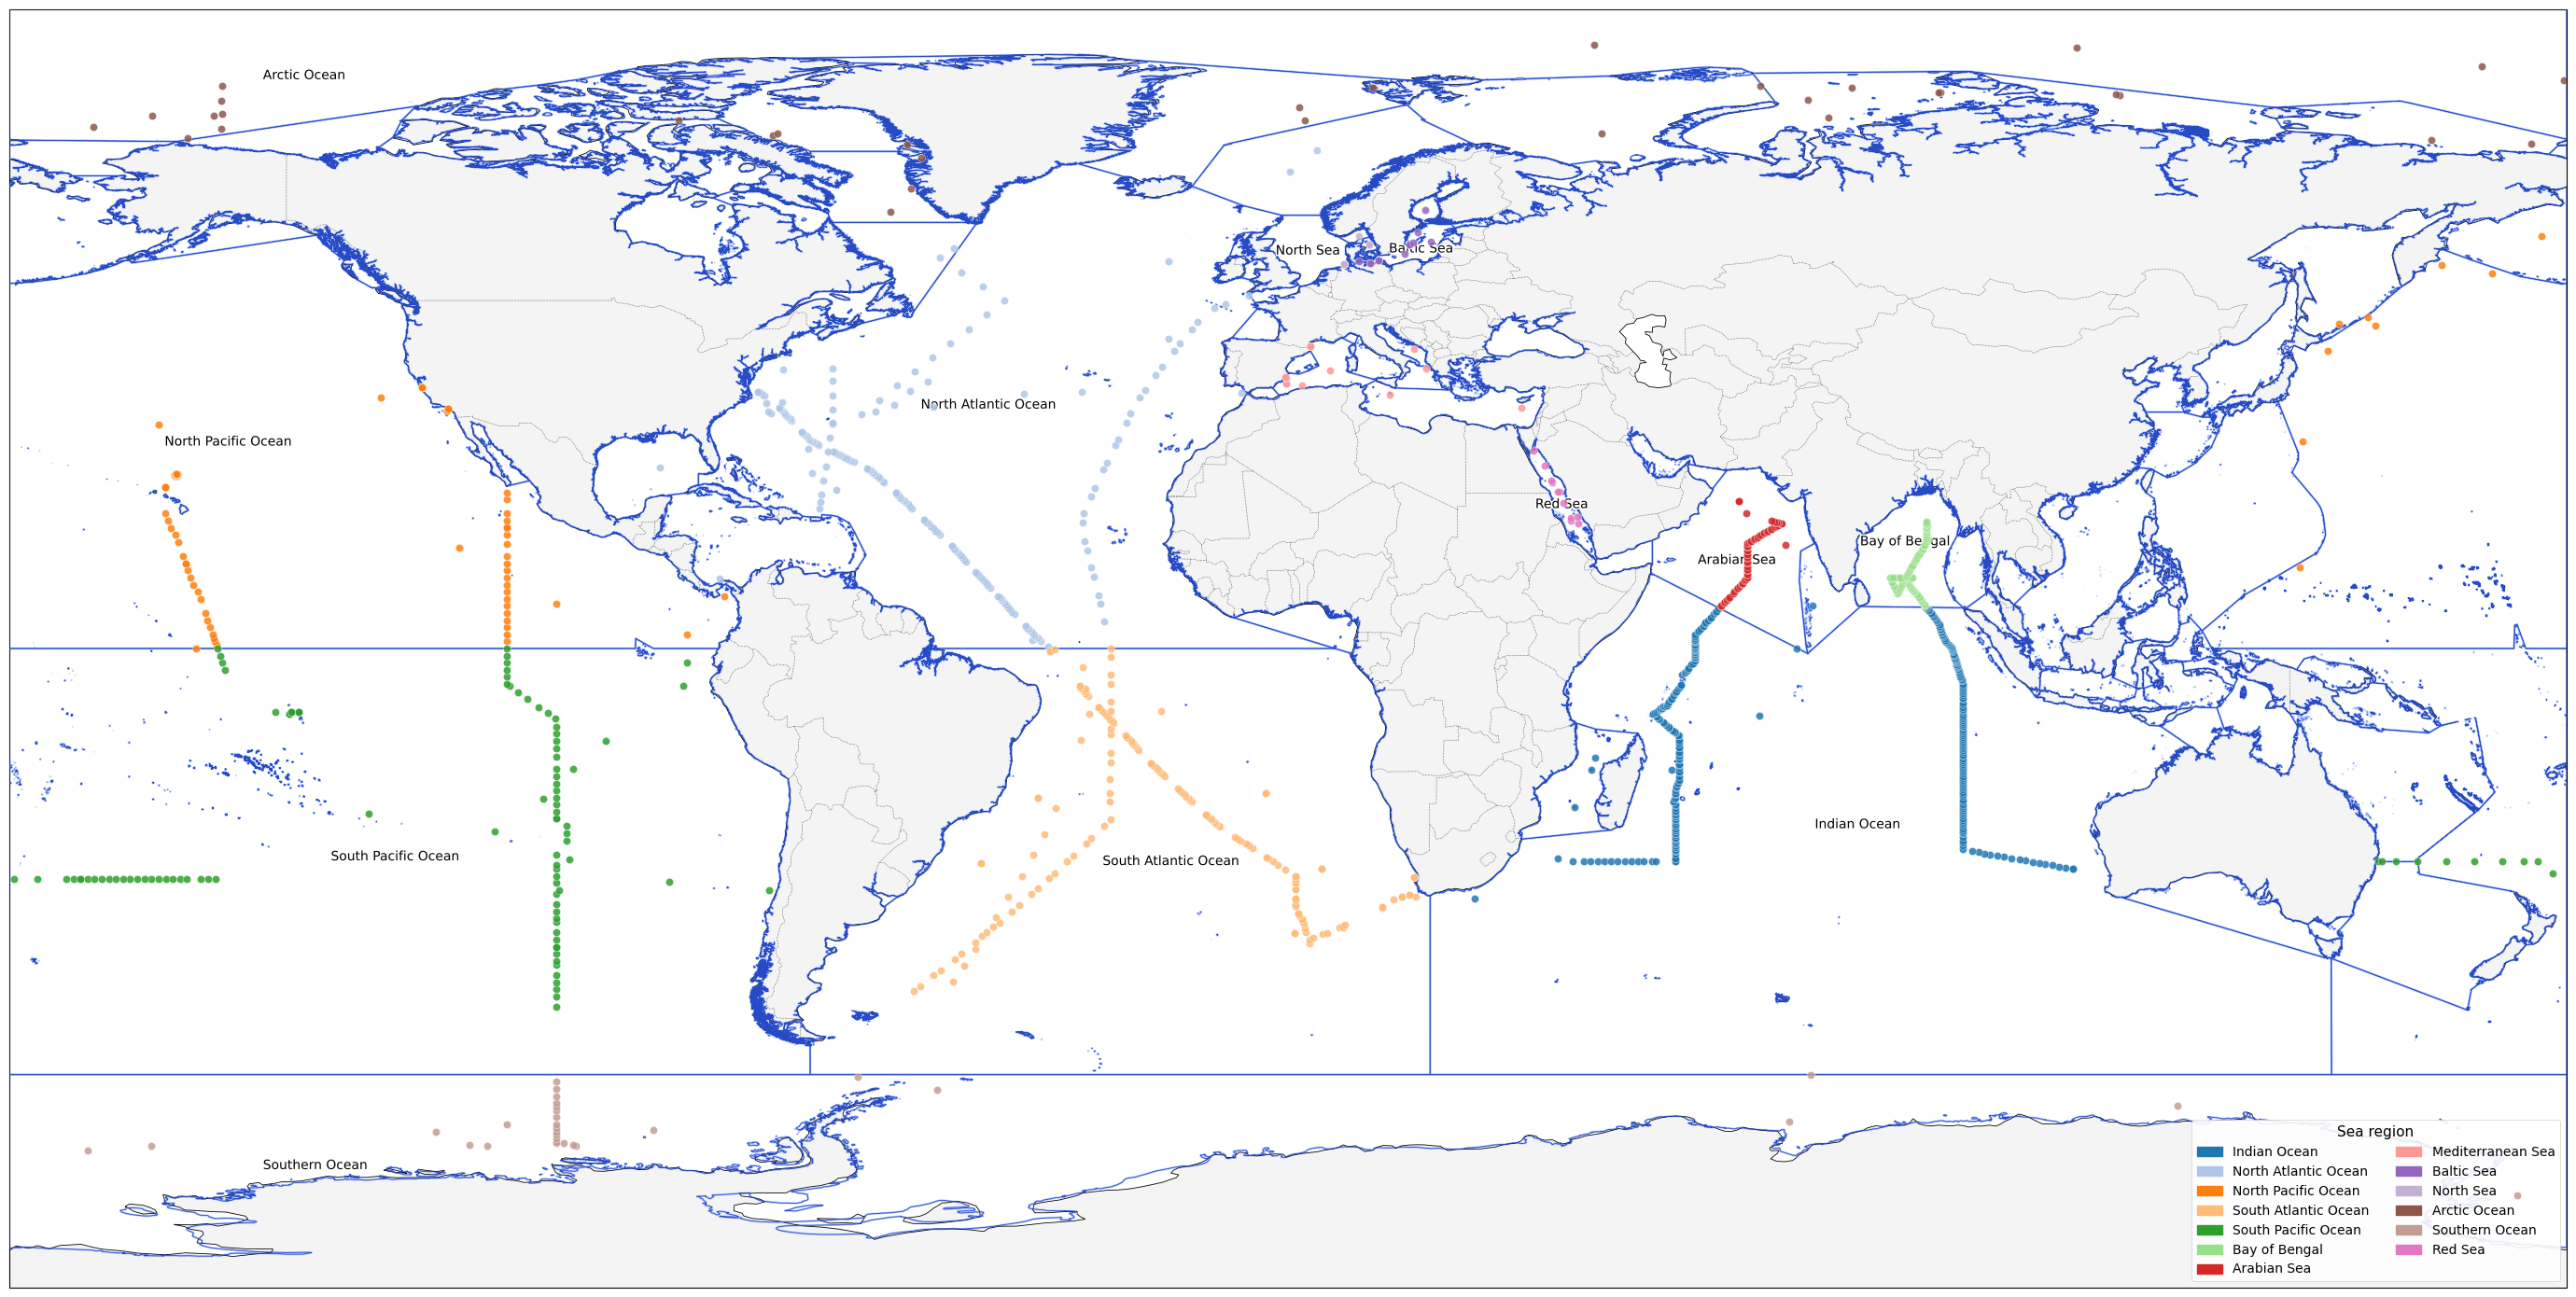

In [ ]:
# ========== 2) Base Map ==========
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(28, 14))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent([-180, 180, -90, 90], crs=proj)

# Natural features
ax.add_feature(cfeature.LAND, facecolor="#f4f4f4", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, zorder=3)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.4, zorder=3)

# ========== 3) Sea Boundaries ==========
for geom in iho_all_diss.geometry:
    ax.add_geometries([geom], crs=proj, facecolor="none",
                      edgecolor="#b5c7ff", linewidth=1.6, zorder=2)
for geom in iho_all_diss.geometry:
    ax.add_geometries([geom], crs=proj, facecolor="none",
                      edgecolor="#264bc5", linewidth=0.6, zorder=3)

# ========== 4) Sea Names ==========
min_area_deg2 = 0.03  # Area threshold can be adjusted as needed
for name, row in iho_labels.iterrows():
    geom = row.geometry
    if isinstance(geom, (Polygon, MultiPolygon)):
        if geom.area < min_area_deg2:
            continue
        pt = geom.representative_point()
        ax.text(
            pt.x, pt.y, name,
            transform=proj,
            fontsize=10, ha="center", va="center", zorder=5,
            path_effects=[pe.Stroke(linewidth=2.2, foreground="white"), pe.Normal()]
        )



# Keep only samples with valid coordinates and known sea regions
samples = meta[["IHO_Sea_comb", "latitude", "longitude"]].rename(columns={
    "IHO_Sea_comb": "sea", "latitude": "lat", "longitude": "lon"
}).copy()

# Clean coordinates
samples["lat"] = pd.to_numeric(samples["lat"], errors="coerce")
samples["lon"] = pd.to_numeric(samples["lon"], errors="coerce")
samples = samples.dropna(subset=["lat", "lon", "sea"])

# Normalize longitude to [-180, 180]
samples.loc[samples["lon"] > 180, "lon"] -= 360
samples.loc[samples["lon"] < -180, "lon"] += 360

# ========== 6) Plot sample points (only 13 target sea areas, excluding Other) ==========
cmap = plt.get_cmap("tab20")
color_map = {sea: cmap(i % 20) for i, sea in enumerate(label_seas)}

handles = []
for sea in label_seas:
    df = samples.loc[samples["sea"] == sea]
    if df.empty:
        continue
    ax.scatter(
        df["lon"], df["lat"],
        s=35, alpha=0.85, transform=proj,
        color=color_map[sea],
        edgecolors="white", linewidths=0.3,
        zorder=7, rasterized=True
    )
    handles.append(mpatches.Patch(color=color_map[sea], label=sea))

# Legend (only 13 target sea areas)
leg = ax.legend(
    handles=handles, title="Sea region",
    loc="lower right", frameon=True, framealpha=0.9,
    ncol=2, fontsize=10, title_fontsize=11
)
leg.get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.show()

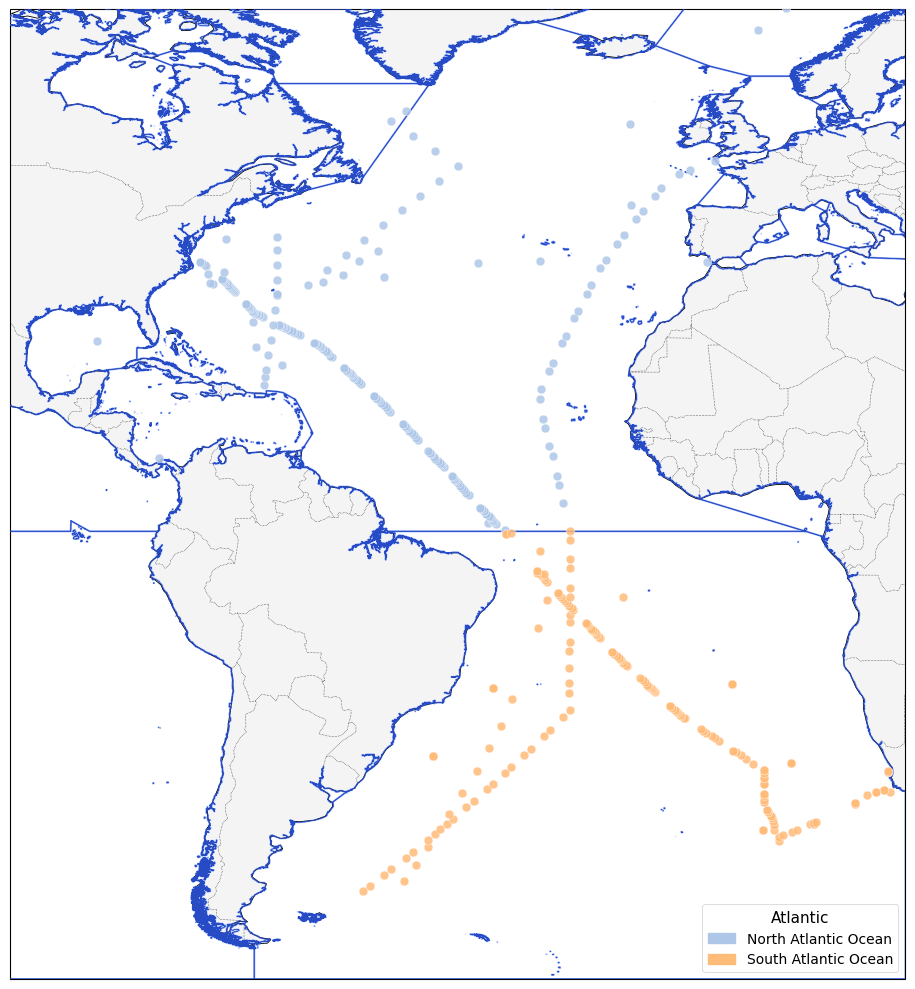

In [24]:
# —— 单独大西洋图 —— #
fig2 = plt.figure(figsize=(14, 10))
ax2 = fig2.add_subplot(1, 1, 1, projection=proj)
ax2.set_extent([-100, 20, -60, 70], crs=proj)

ax2.add_feature(cfeature.LAND, facecolor="#f4f4f4", zorder=0)
ax2.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.6, zorder=3)
ax2.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.4, zorder=3)

# 边界
for geom in iho_all_diss.geometry:
    ax2.add_geometries([geom], crs=proj, facecolor="none",
                       edgecolor="#b5c7ff", linewidth=1.4, zorder=2)
for geom in iho_all_diss.geometry:
    ax2.add_geometries([geom], crs=proj, facecolor="none",
                       edgecolor="#264bc5", linewidth=0.6, zorder=3)

# 只画大西洋点，点更大 + 透明度略降
handles2 = []
for sea in ["North Atlantic Ocean", "South Atlantic Ocean"]:
    df = samples.loc[samples["sea"] == sea]
    if df.empty:
        continue
    sc = ax2.scatter(
        df["lon"], df["lat"],
        s=40, alpha=0.85, transform=proj,
        color=color_map[sea], edgecolors="white", linewidths=0.3,
        zorder=7, rasterized=True
    )
    handles2.append(mpatches.Patch(color=color_map[sea], label=sea))

leg2 = ax2.legend(
    handles=handles2, title="Atlantic",
    loc="lower right", frameon=True, framealpha=0.9, fontsize=10, title_fontsize=11
)
leg2.get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.show()
